<a href="https://colab.research.google.com/github/neeraj-iitm/Kalman-Filter-for-Manoeuvring-Targets/blob/main/KF_Simulation_Single_Component_of_Spiral_Trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  $ \Huge \ \ -- \ Simulation \ --$


## Import
Lets Start by importing necessary libraries,

In [ ]:
#---- Local Imports
from utils.PQ_matrices import P_cov, Q_cov
from utils.transfer_function import *
import utils.syntheticmeasurements as sms
from utils.mkf_internal import plot_track
from book_plots import reset_figsize

#---- Library Imports
import numpy as np
from matplotlib.pyplot import text
# from numpy import exp
from numpy.random import randn
from scipy.linalg import inv


#---- Plot imports
import matplotlib.pyplot as plt


## Intiate Variables and Compute Matrices
Lets declare our variables and find out the required Matrices. The values are taken directly from research paper.

In [ ]:
Amax =  4*9.8
Pmax = 0.1
P_o = 0.5

T = 1
α = 0.01

$\sigma _m ^2 = \frac{A_{max}^2}{3}\times(1+4P_{max} - P_o)$

$\Phi(T, \alpha)=\left[\begin{array}{ccc}
1 & T & \frac{1}{\alpha^{2}}\left[-1+\alpha T+e^{-\alpha T}\right] \\
0 & 1 & \frac{1}{\alpha}\left[1-e^{-\alpha T}\right] \\
0 & 0 & e^{-a T}
\end{array}\right]\quad \quad \quad \quad$


$Q(k)=E\left[u(k) u^{T}(k)\right]=2 \alpha \sigma_{m}^{2}\left[\begin{array}{ccc}
q 11 & q 12 & q 13 \\
q 12 & q 22 & q 23 \\
q 13 & q 23 & 433
\end{array}\right]$

In [ ]:
σ_m = (((Amax**2)/3)*(1+4*Pmax - P_o))**0.5
σ_r = 0.5

P = P_cov(σ_r,σ_m,α,T)
Q = Q_cov(σ_m, α,T)
R = np.array([[σ_r**2]])
# P = np.diag([1,1,1])
# Q = np.diag([1,1,1])
# R = np.array([[]]) 

F = transfer_function(α,T)
H = np.array([[1., 0., 0.]])
x = np.array([[0, 0, 0 ]]).T
dt = 0.1

## Get Measurements

```breakpoints``` determine the time instats in which acceleration is changed. The respective acceleration magnitudes are given in ```manoeuvres```. Length of both ```breakpoins``` and ``` manoeuvres``` should be same.

In [ ]:
breakpoints = [0., 50.,  60., 80,   100, 120,  140,  160,   190, 200.,   210.,  250.,  280., 300,   320, 340, 360,380] 
manoeuvres =  [0,  Amax, 0,  -Amax, Amax, 0,   Amax, -Amax, Amax, 0.0,   -Amax,  Amax,   0,  Amax, -Amax, Amax, -Amax,0]

```Synthetic_Measurement``` is imported from utils folder as ```sms```. This ```class```  develops both true values and their synthetic measuremnt values by adding random noise to them.

In [ ]:
sm = sms.Synthetic_Measurement(σ_m,
                               σ_r,
                               breakpoints = breakpoints, 
                               manoeuvres = manoeuvres,
                               count=600)

```xm``` and ```vm``` are measured position and velocity vectors, including the noise. The noise might not be visible in position because relative magnitude of noise with respect to values of position is very small. The noise in velocity is evident however.

In [ ]:
xm,vm =sm.meas_sim(1, 
                  start_pos=6000,
                  pprint = 1)

## $ \textbf{Apply Kalman  Filter}$


The objective of the paper was to find out the $\text{Transition matrix} \ \Phi$ and the covariance matrices for the given problem. This snippet executes the Kalman Filter using the respective $P$ and $Q$ covariance matrices from paper.

In [ ]:
θ = np.arange(-3.14*10, 3.14*10, 0.1)
r = [10+0.1*i for i in range(len(θ))]

xc = [r[i]*np.cos(j) for (i,j) in enumerate(θ)]
yc = [r[i]*np.sin(j) for (i,j) in enumerate(θ)]

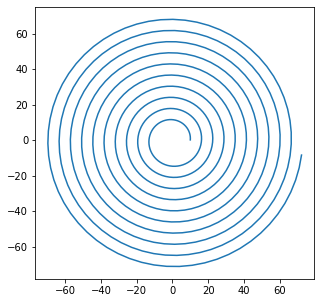

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(xc,yc)

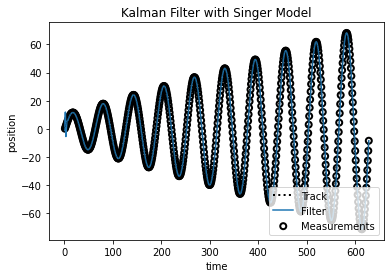

In [ ]:
xs =[]
cov= []

for z in yc:
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], yc, yc, cov, plot_P=0,title="Kalman Filter with Singer Model")


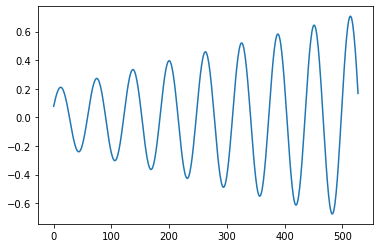

In [ ]:
asst=[]
asst =[xs[ii][2] for ii in range(len(xs))]
plt.plot(asst[100:19800])